# Coregionalized Gaussian Process Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re
import pymc3 as pm
import arviz as az
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise as pw
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.moment_helpers import cov2corr
from pathlib import Path  

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC3 v3.11.4
Running on ArviZ v0.11.2


In [3]:
%cd "C:\\Users\\Jared\\Desktop\\Lead Hazard"

C:\Users\Jared\Desktop\Lead Hazard


In [4]:
log_data = pd.read_csv("Log Transformed Data.csv")

In [5]:
print(f'The total area we are dealing with:')
print(f'West-East: {log_data["X Loc"].min()}  to  {log_data["X Loc"].max()}')
print(f'South-North: {log_data["Y Loc"].min()}  to  {log_data["Y Loc"].max()}')

The total area we are dealing with:
West-East: -5.0  to  13.0
South-North: -6.0  to  5.0


## Bayesian Spatial Modeling

Template of all locations within this rectangle, for predictions later

In [6]:
# loop through possible locations
X_xrf_all = []
X_soil_all = []
for i in range(-5,14):
    for j in range(-6,6):
        X_xrf_all.append([0,i,j]) # first column is id column, signifying categorical xrf vs soil marker
        X_soil_all.append([1,i,j]) # 0 for xrf, 1 for soil

# list to array
X_xrf_all = np.array(X_xrf_all)
X_soil_all = np.array(X_soil_all)

# stack them together
X_all = np.concatenate([X_xrf_all,X_soil_all], axis=0)

**n** xrf samples and **n** soil samples

In [7]:
# set up variables
coordinates = log_data.loc[:,["X Loc","Y Loc"]].values
y_xrf = log_data["XRF (ppm)"].values
y_soil = log_data["Soil (ppm)"].values
n = y_soil.shape[0]

Train-Test Split

In [8]:
SEED = 3954349#0
np.random.seed(SEED)
where = np.random.random(n) < 0.70

# inputs
X_test_pre, X_train_pre = coordinates[~where,:], coordinates[where,:]

# outputs
y_xrf_test, y_xrf_train = y_xrf[~where], y_xrf[where]
y_soil_test, y_soil_train = y_soil[~where], y_soil[where]

print(f'Training Obs: {X_train_pre.shape[0]*2}, Testing Obs: {X_test_pre.shape[0]*2}')
print('Half xrf samples, half soil samples')

Training Obs: 64, Testing Obs: 14
Half xrf samples, half soil samples


**2n** observations stacked (this GP format requires an id column)

In [9]:
# add id column
X0_train = np.concatenate([np.zeros(X_train_pre.shape[0]).reshape(-1,1), X_train_pre], axis = 1) 
X1_train = np.concatenate([np.ones(X_train_pre.shape[0]).reshape(-1,1), X_train_pre], axis = 1)
X0_test = np.concatenate([np.zeros(X_test_pre.shape[0]).reshape(-1,1), X_test_pre], axis = 1) 
X1_test = np.concatenate([np.ones(X_test_pre.shape[0]).reshape(-1,1), X_test_pre], axis = 1)

# stack the input data
X_test, X_train = np.concatenate([X0_test, X1_test], axis = 0) , np.concatenate([X0_train, X1_train], axis = 0)

# stack the output data
y_test, y_train = np.concatenate([y_xrf_test, y_soil_test], axis = 0), np.concatenate([y_xrf_train, y_soil_train], axis = 0)

**2** target types (multi-output GPR | coregionalization)

In [10]:
n_out = 2
id_col = 0

Hyperparameter Initialization

In [11]:
distances_matrix = pw.euclidean_distances(coordinates)
distances = distances_matrix[np.triu_indices(distances_matrix.shape[0])]
nonzero_distances = distances[distances != 0]
distances_sd = distances.std()
nonzero_distances_sd = nonzero_distances.std()

in_sd = distances_sd
out_sd = np.concatenate([y_xrf,y_soil]).std()

print(f'SD of Log Response Data: {round(1000*out_sd)/1000}')
print(f'SD of Distances Btwn Points: {round(1000*distances_sd)/1000}, D of *Nonzero* Distances Btwn Points: {round(1000*nonzero_distances_sd)/1000}')

SD of Log Response Data: 0.517
SD of Distances Btwn Points: 4.666, D of *Nonzero* Distances Btwn Points: 4.503


In [12]:
multiplier = 10
hyper_init = {'ℓ': multiplier * in_sd,
              'η': multiplier * out_sd,
              'W': (0, # mean
                    multiplier * out_sd), # sd
              'κ': multiplier * out_sd, 
              'σ': multiplier * out_sd}

## Predicting Both XRF and Soil from Location

### Modeling

Try different kernels, try different priors

In [13]:
with pm.Model() as model:
    
    # parameters
    # ℓ - length scale (input variation, spatial)
    # η - amplitude (output variation, lead levels)
    # W - similarity in covariance between two GPs
    # κ - difference in covariance between two GPs
    # σ - noise above and below GP curves
    
    # priors
    ℓ = pm.HalfCauchy("ℓ", beta = hyper_init["ℓ"])
    η = pm.HalfCauchy("η", beta = hyper_init["η"])
    cov = η**2 * pm.gp.cov.Matern52( # first covariance matrix
        input_dim = n_out+1,
        ls = ℓ,
        active_dims = np.arange(1, n_out+1))

    # coregionalization
    W = pm.Normal("W", mu = hyper_init["W"][0], sd = hyper_init["W"][1], shape = (n_out, n_out-1))
    κ = pm.HalfCauchy("κ", beta = hyper_init["κ"], shape = n_out)
    coreg = pm.gp.cov.Coregion( # second covariance matrix
        input_dim = n_out+1,
        active_dims = [id_col], # just the id column
        kappa = κ,
        W = W)

    # noise
    σ = pm.HalfCauchy("σ", beta = hyper_init["σ"])
    
    # combine the covariances
    cov_combined = coreg * cov

    # gaussian process
    gp = pm.gp.Marginal(cov_func = cov_combined)

    # likelihood
    y_ = gp.marginal_likelihood("y", X = X_train, y = y_train, noise = σ)
    
    pred_ = gp.conditional("pred_", X_test)
    #pred_xrf_all = gp.conditional("pred_xrf_all", X_xrf_all)
    #pred_soil_all = gp.conditional("pred_soil_all", X_soil_all)

### Sampling

MSE

In [14]:
# calculate mse
def mse(actual, pred):
    return ((actual - pred)**2).sum()

In [15]:
xrf_mses = []
soil_mses = []

Sampling

In [22]:
list_of_ndraws = [1,10,100,1000]

for ndraws in list_of_ndraws:

    #ndraws = 40
    nburn = 100
    nchains = 1

    with model:

        # full posterior sampling
        trace = pm.sample(draws=ndraws, chains=nchains, cores=4, tune=nburn, target_accept = .92, discard_tuned_samples=True, return_inferencedata=True)
        
    # the samples and their respective means
    pred_test_samples = np.array(trace.posterior["pred_"][0])
    pred_test_hat = pred_test_samples.mean(axis = 0)

    # get indices for splitting
    end_of_pred_xrf_indices = X_test[X_test[:,0] == 0].shape[0]
    
    # actual samples: y_xrf_test

    # pred samples and mean estimate
    pred_xrf_test_samples = pred_test_samples[:end_of_pred_xrf_indices]
    pred_xrf_test_hat = pred_test_hat[:end_of_pred_xrf_indices]
    
    # actual samples: y_soil_test

    # pred samples and mean estimate
    pred_soil_test_samples = pred_test_samples[end_of_pred_xrf_indices:]
    pred_soil_test_hat = pred_test_hat[end_of_pred_xrf_indices:]
    
    xrf_mses.append(mse(y_xrf_test,pred_xrf_test_hat))
    soil_mses.append(mse(y_soil_test,pred_soil_test_hat))

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 1 draw iterations (100 + 1 draws total) took 56 seconds.
C:\Users\Jared\anaconda3\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 10 draw iterations (100 + 10 draws total) took 70 seconds.
C:\Users\Jared\anaconda3\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 107 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 499 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


### Held-Out Predictive Likelihood Validation - Log Space

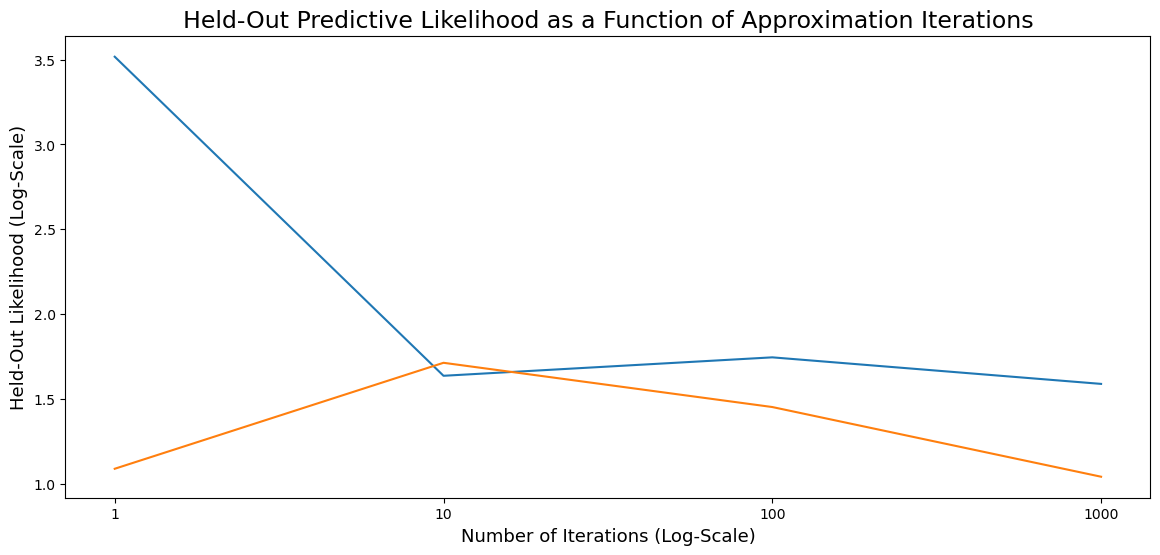

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.plot(xrf_mses)
ax.plot(soil_mses)
ax.set_title("Held-Out Predictive Likelihood as a Function of Approximation Iterations", fontsize = 17)
ax.set_xlabel("Number of Iterations (Log-Scale)", fontsize = 13)
ax.set_ylabel("Held-Out Likelihood (Log-Scale)", fontsize = 13)
ax.set_xticks([0,1,2,3])
ax.set_xticklabels([1,10,100,1000])
plt.show()

Held-Out Test Data All Samples

In [28]:
# the samples and their respective means
pred_test_samples = np.array(trace.posterior["pred_"][0])
pred_test_hat = pred_test_samples.mean(axis = 0)

# get indices for splitting
end_of_pred_xrf_indices = X_test[X_test[:,0] == 0].shape[0]

Held-Out Test Data XRF 

In [29]:
# actual samples: y_xrf_test

# pred samples and mean estimate
pred_xrf_test_samples = pred_test_samples[:,:end_of_pred_xrf_indices]
pred_xrf_test_hat = pred_test_hat[:end_of_pred_xrf_indices]

In [30]:
print(f'Log Space XRF MSE: {round(10000*mse(y_xrf_test,pred_xrf_test_hat))/10000}')

Log Space XRF MSE: 1.59


Held-Out Test Data Soil

In [31]:
# actual samples: y_soil_test

# pred samples and mean estimate
pred_soil_test_samples = pred_test_samples[:,end_of_pred_xrf_indices:]
pred_soil_test_hat = pred_test_hat[end_of_pred_xrf_indices:]

In [32]:
print(f'Log Space Soil MSE: {round(10000*mse(y_soil_test,pred_soil_test_hat))/10000}')

Log Space Soil MSE: 1.0434


### Held-Out Predictive Likelihood Validation - Original Space

Exponentiate back to the original space

In [33]:
exp_y_xrf_test = 10 ** y_xrf_test
exp_y_soil_test = 10 ** y_soil_test
exp_y_test = np.concatenate([exp_y_xrf_test,exp_y_soil_test])

exp_pred_test_samples = 10 ** pred_test_samples
exp_pred_test_hat = np.round(exp_pred_test_samples.mean(axis = 0))

Held-Out Test Data XRF 

In [34]:
# actual samples: y_xrf_test

# pred samples and mean estimate
exp_pred_xrf_test_samples = exp_pred_test_samples[:,:end_of_pred_xrf_indices]
exp_pred_xrf_test_hat = exp_pred_test_hat[:end_of_pred_xrf_indices]

In [35]:
print(f'Log Space XRF MSE: {round(mse(exp_y_xrf_test,exp_pred_xrf_test_hat))}')

Log Space XRF MSE: 332567152


Held-Out Test Data Soil

In [36]:
# actual samples: y_soil_test

# pred samples and mean estimate
exp_pred_soil_test_samples = exp_pred_test_samples[:,end_of_pred_xrf_indices:]
exp_pred_soil_test_hat = exp_pred_test_hat[end_of_pred_xrf_indices:]

In [37]:
print(f'Log Space Soil MSE: {round(mse(exp_y_soil_test,exp_pred_soil_test_hat))}')

Log Space Soil MSE: 8074155


In [38]:
exp_pred_test_hat

array([  593.,   671., 21313.,  1540.,   723.,   384.,  1390.,   539.,
        1003.,  8722.,   510.,  1379.,   430.,  2614.])

In [39]:
exp_y_test

array([ 518. ,   15. , 3175. ,  583. , 1786. ,  389. ,  342. , 1230. ,
         38.8, 7660. ,  645. , 1640. ,  261. ,  285. ])

### Unobserved Covariate Predictive Sampling

In [40]:
n_pred_samples = 50

with model:
    
    # predictions
    #pred_ = gp.conditional("pred_", X_test)
    
    pred_all = gp.conditional("pred_all", X_all)
    #"pred_",
    pred_samples = pm.sample_posterior_predictive(trace=trace, var_names=["pred_all"], samples=n_pred_samples)

C:\Users\Jared\anaconda3\lib\site-packages\pymc3\sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


### Estimates and Credible Intervals

Parameter Summary Statistics

In [41]:
az.summary(trace, var_names=["ℓ","η","W","κ","σ"], round_to=2)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ,5.23,1.72,3.27,7.63,0.09,0.06,375.72,414.48,NaN
η,0.32,0.15,0.12,0.60,0.01,0.00,706.98,732.15,NaN
"W[0,0]",6.64,2.21,2.65,11.03,0.09,0.07,605.57,612.08,NaN
"W[1,0]",6.69,2.23,2.38,10.69,0.09,0.07,623.51,617.52,NaN
κ[0],2.55,3.19,0.00,7.76,0.14,0.10,313.57,365.81,NaN
κ[1],2.51,3.04,0.00,7.89,0.10,0.07,498.85,174.28,NaN
σ,0.24,0.05,0.16,0.33,0.00,0.00,504.39,436.72,NaN


Trace Plotting

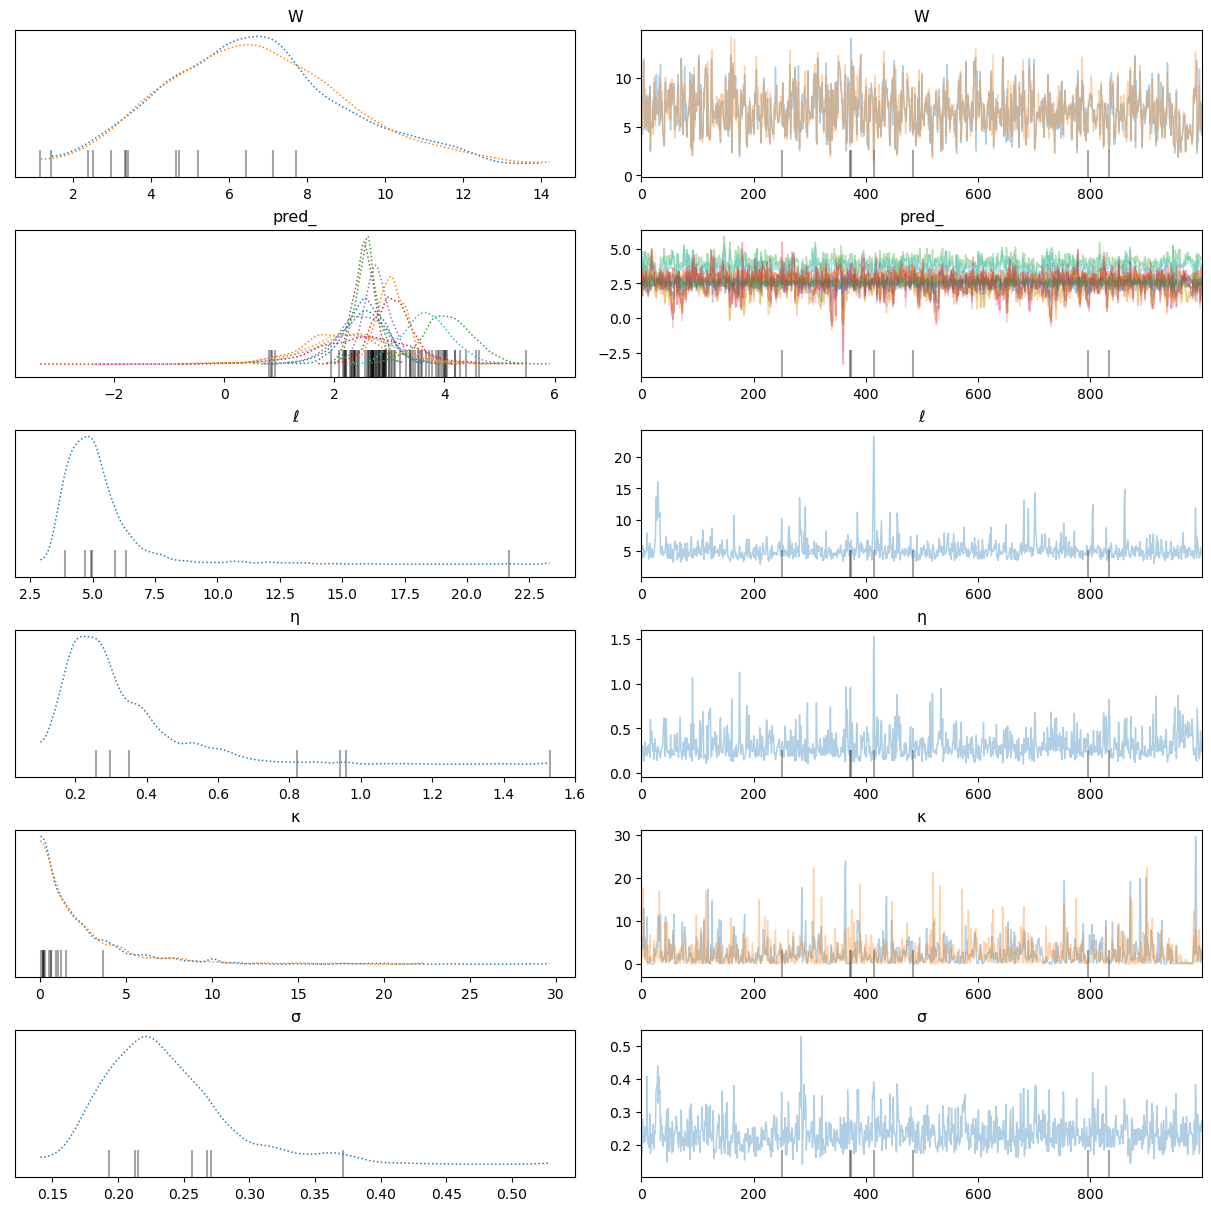

In [42]:
az.plot_trace(trace, combined=True);

Parameter Credible Intervals

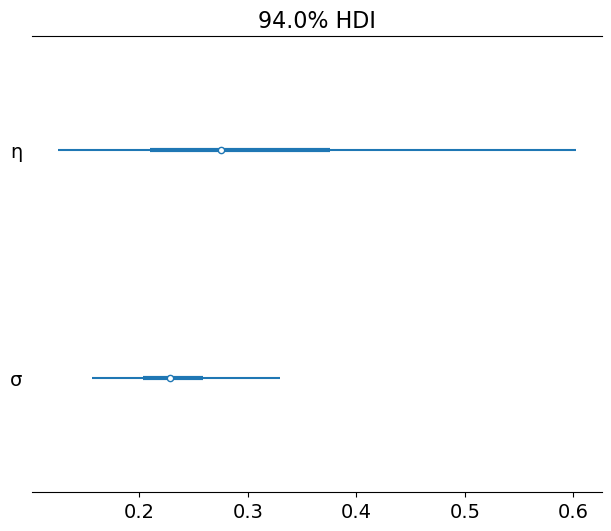

In [43]:
az.plot_forest(trace, var_names=["η","σ"]);

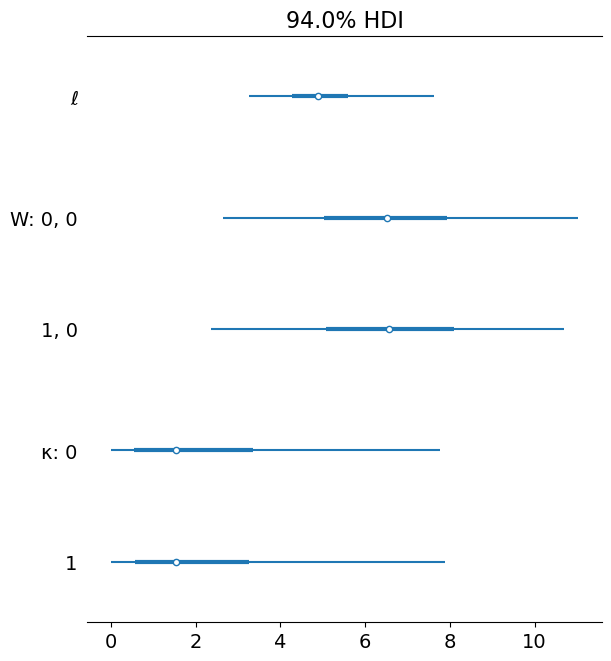

In [44]:
az.plot_forest(trace, var_names=["ℓ","W","κ"]);

Prediction Credible Intervals

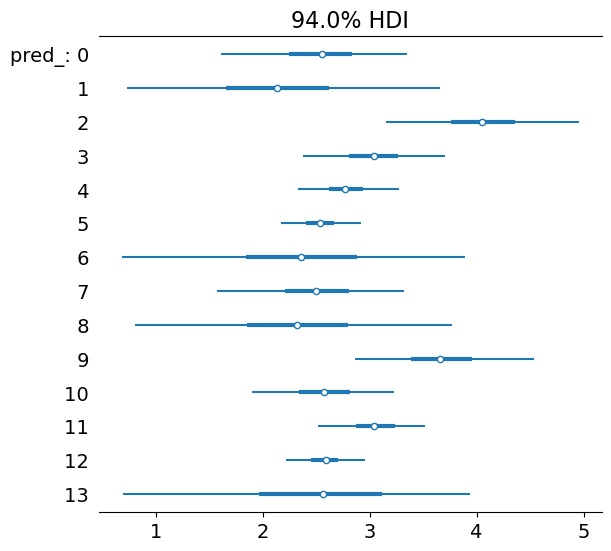

In [45]:
az.plot_forest(trace, var_names="pred_");

Covariance Structure Between GPs

In [46]:
Bs = []
for w, κ, σ in zip(np.array(trace.posterior["W"][0]), np.array(trace.posterior["κ"][0]), np.array(trace.posterior["σ"][0])):
    B = w @ w.T + np.diag(κ) + np.diag(np.array([σ**2,σ**2]))
    Bs.append(B)
cov_hat = B_mean = np.mean(Bs, axis=0)
corr_hat = cov2corr(B_mean)

In [47]:
cov_hat

array([[51.61754116, 48.96658118],
       [48.96658118, 52.27541816]])

In [48]:
corr_hat

array([[1.        , 0.94265412],
       [0.94265412, 1.        ]])

Credible Interval for Correlation

In [49]:
corr_samples = pd.Series(Bs).apply(lambda B: cov2corr(B)[0,1]).values
corr_samples = np.sort(corr_samples)
confidence = .95
lowerbound_prob = (1 - confidence) / 2
upperbound_prob = 1 - lowerbound_prob
lowerbound_index = round(corr_samples.shape[0]*lowerbound_prob)
upperbound_index = round(corr_samples.shape[0]*upperbound_prob)
lowerbound = corr_samples[lowerbound_index]
upperbound = corr_samples[upperbound_index]
lowerbound, upperbound

(0.8184524242444108, 0.9913376782422504)

### Unobserved Covariate Prediction Heatmaps (All Locations) - Log Scale

All Locations

In [ ]:
pred_all = pred_samples["pred_all"] 
# xrf
pred_xrf_all_samples = pred_all[:,:int(X_all.shape[0]/2)]
pred_xrf_all_hat = pred_xrf_all_samples.mean(axis = 0)
# soil
pred_soil_all_samples = pred_all[:,int(X_all.shape[0]/2):]
pred_soil_all_hat = pred_soil_all_samples.mean(axis = 0)

Generate Location-Based DataFrame

In [ ]:
# generator df with all locations
def blank_df():
    return pd.DataFrame(index=range(-6,6), columns=range(-5,14), dtype = 'float')

Templates

In [ ]:
# initialize
heatmap_xrf_all = blank_df()
heatmap_soil_all = blank_df()

XRF

In [ ]:
for i in range(pred_xrf_all_hat.shape[0]):
    x1loc = X_xrf_all[i,1]
    x2loc = X_xrf_all[i,2]
    heatmap_xrf_all.loc[x2loc,x1loc] = pred_xrf_all_hat[i]

In [ ]:
sns.heatmap(data = heatmap_xrf_all)
plt.title("Log XRF Heatmap")
plt.xlabel("West-East")
plt.ylabel("South-North")
ax = plt.gca()
ax.invert_yaxis()

plt.show()

Soil

In [ ]:
for i in range(pred_soil_all_hat.shape[0]):
    x1loc = X_soil_all[i,1]
    x2loc = X_soil_all[i,2]
    heatmap_soil_all.loc[x2loc,x1loc] = pred_soil_all_hat[i]

In [ ]:
sns.heatmap(data = heatmap_soil_all)
plt.title("Log Soil Heatmap")
plt.xlabel("West-East")
plt.ylabel("South-North")
ax = plt.gca()
ax.invert_yaxis()

plt.show()

Difference

In [ ]:
sns.heatmap(data = heatmap_xrf_all - heatmap_soil_all, vmin = -1, vmax = 1)
plt.title("Difference in Log XRF and Log Soil Heatmap")
plt.xlabel("West-East")
plt.ylabel("South-North")
ax = plt.gca()
ax.invert_yaxis()

plt.show()

### Unobserved Covariate Prediction Heatmaps (All Locations) - Original Scale

In [ ]:
exp_pred_all = 10 ** pred_all
# xrf
exp_pred_xrf_all_samples = exp_pred_all[:,:int(X_all.shape[0]/2)]
exp_pred_xrf_all_hat = np.round(exp_pred_xrf_all_samples.mean(axis = 0))
# soil
exp_pred_soil_all_samples = exp_pred_all[:,int(X_all.shape[0]/2):]
exp_pred_soil_all_hat = np.round(exp_pred_soil_all_samples.mean(axis = 0))

In [ ]:
# initialize
heatmap_exp_xrf_all = blank_df()
heatmap_exp_soil_all = blank_df()

In [ ]:
for i in range(exp_pred_xrf_all_hat.shape[0]):
    x1loc = X_soil_all[i,1]
    x2loc = X_soil_all[i,2]
    heatmap_exp_xrf_all.loc[x2loc,x1loc] = exp_pred_xrf_all_hat[i]

In [ ]:
sns.heatmap(data = heatmap_exp_xrf_all)
plt.title("XRF Heatmap")
plt.xlabel("West-East")
plt.ylabel("South-North")
ax = plt.gca()
ax.invert_yaxis()

plt.show()

In [ ]:
for i in range(exp_pred_soil_all_hat.shape[0]):
    x1loc = X_soil_all[i,1]
    x2loc = X_soil_all[i,2]
    heatmap_exp_soil_all.loc[x2loc,x1loc] = exp_pred_soil_all_hat[i]

In [ ]:
sns.heatmap(data = heatmap_exp_soil_all)
plt.title("Soil Heatmap")
plt.xlabel("West-East")
plt.ylabel("South-North")
ax = plt.gca()
ax.invert_yaxis()

plt.show()

In [ ]:
sns.heatmap(data = heatmap_exp_xrf_all - heatmap_exp_soil_all)
plt.title("Difference in Log XRF and Log Soil Heatmap")
plt.xlabel("West-East")
plt.ylabel("South-North")
ax = plt.gca()
ax.invert_yaxis()

plt.show()

## Predicting Soil from XRF and Location

In [18]:
X_train2 = np.concatenate([X_train,X_test[:X_test.shape[0]//2,:]], axis=0)
y_train2 = np.concatenate([y_train,y_test[:y_test.shape[0]//2]])
X_test2 = X_test[X_test.shape[0]//2:,:]

In [19]:
with pm.Model() as model2:
    
    # parameters
    # ℓ - length scale (input variation, spatial)
    # η - amplitude (output variation, lead levels)
    # W - similarity in covariance between two GPs
    # κ - difference in covariance between two GPs
    # σ - noise above and below GP curves
    
    # priors
    ℓ = pm.HalfCauchy("ℓ", beta = hyper_init["ℓ"])
    η = pm.HalfCauchy("η", beta = hyper_init["η"])
    cov = η**2 * pm.gp.cov.Matern52( # first covariance matrix
        input_dim = n_out+1,
        ls = ℓ,
        active_dims = np.arange(1, n_out+1))

    # coregionalization
    W = pm.Normal("W", mu = hyper_init["W"][0], sd = hyper_init["W"][1], shape = (n_out, n_out-1))
    κ = pm.HalfCauchy("κ", beta = hyper_init["κ"], shape = n_out)
    coreg = pm.gp.cov.Coregion( # second covariance matrix
        input_dim = n_out+1,
        active_dims = [id_col], # just the id column
        kappa = κ,
        W = W)

    # noise
    σ = pm.HalfCauchy("σ", beta = hyper_init["σ"])
    
    # combine the covariances
    cov_combined = coreg * cov

    # gaussian process
    gp = pm.gp.Marginal(cov_func = cov_combined)

    # likelihood
    y_ = gp.marginal_likelihood("y", X = X_train2, y = y_train2, noise = σ)
    
    pred_ = gp.conditional("pred_", X_test2)
    #pred_xrf_all = gp.conditional("pred_xrf_all", X_xrf_all)
    #pred_soil_all = gp.conditional("pred_soil_all", X_soil_all)

In [20]:
xrf_mses2 = []
soil_mses2 = []

In [21]:
list_of_ndraws = [1,10,100,1000]

for ndraws in list_of_ndraws:

    #ndraws = 40
    nburn = 100
    nchains = 1

    with model2:

        # full posterior sampling
        trace = pm.sample(draws=ndraws, chains=nchains, cores=4, tune=nburn, target_accept = .92, discard_tuned_samples=True, return_inferencedata=True)
        
    # the samples and their respective means
    pred_test_samples = np.array(trace.posterior["pred_"][0])
    pred_test_hat = pred_test_samples.mean(axis = 0)

    # actual samples: y_soil_test

    # pred samples and mean estimate
    pred_soil_test_samples = pred_test_samples
    pred_soil_test_hat = pred_test_hat
    
    soil_mses2.append(mse(y_soil_test,pred_soil_test_hat))

Only 1 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 1 draw iterations (100 + 1 draws total) took 33 seconds.
C:\Users\Jared\anaconda3\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 10 draw iterations (100 + 10 draws total) took 30 seconds.
C:\Users\Jared\anaconda3\lib\site-packages\pymc3\sampling.py:643: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 100 draw iterations (100 + 100 draws total) took 64 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [pred_, σ, κ, W, η, ℓ]


Sampling 1 chain for 100 tune and 1_000 draw iterations (100 + 1_000 draws total) took 288 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [26]:
soil_mses

[1.0902523795353714,
 1.7143063368615887,
 1.4537575113791195,
 1.0433763187928766]

In [27]:
soil_mses2

[3.125776236760133, 0.5935467121638597, 0.7765754060335527, 0.785465098607893]